# Projet 7-2: Global database construction

As seen in the Exploratory Data Analysis notebook, there are a large number of databases available: application_test, application_train, bureau, bureau_balance, credit_card_balance, HomeCredit_columns_description, installments_payments, POS_CASH_balance, previous_application, sample_submission. Not all of these bases are actually usable.

- HomeCredit_columns_description is a file which gives additional information on the features of each database.  
- Sample_submission is a two columns database with predictions (or some kind of) made on application_test database.  

In order to make a general base to train and select a model we have to merge the bases with the good preliminary treatments (e.g. identification of anomalous values and outliers, statistic computations and merging through clients' identification number).  

For reasons of consistency we will do the same with the application_test database even if it will not be directly used for training models. 

In [1]:
# File system management
import os

In [2]:
# memory management
import sys
import gc

In [3]:
# Main libraries
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Secondary libraries
import timeit

In [4]:
# Mode 'dark' for plottings
plt.style.use('dark_background')

In [5]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

### Functions used in this notebook

The function below will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [6]:
def convert_types(df, print_info = False):
    """
    Convert data types into more suitable ones in
    order to reduce the volume of the input dataframe.
    
    parameter
    ---------
    df = dataframe
    """
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for col in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in col):
            df[col] = df[col].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[col].dtype == 'object') and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype('category')
        
        # Booleans mapped to integers
        elif set(df[col].unique()) == {1, 0}:
            df[col] = df[col].astype(bool)
        
        # Float64 to float32
        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)
            
        # Int64 to int32
        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [7]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

The functions below detect and remove respectively the anomalous value 365243 in DAYS_... features, and outliers in all numerical data with more than three unique values (the flag and rank features must elude the processing).

In [8]:
def spot_365243(df):
    
    """
    Detects the '365243.0' values in an input dataframe

    Parameters
    ----------
    df : dataframe 
        The dataframe in which we want to spot this anomalous value.
        
    Return
    ------
    feature_list : list
        A list of the features in which the anomalous value has been spoted.
        
    """    
    
    features_list=list()
    
    for col in df:
        if 365243 in df[col].drop_duplicates().to_numpy() and 'SK_ID' not in col:
            features_list.append(col)
            
    if len(features_list)==0:
        print('No 365243 anomalous value in this dataframe.')
    else:
        return features_list

In [9]:
def remove_365243(df,features_list):
    
    """
    Detects and replace the '365243.0' in DAYS_... features of an input dataframe
    with nan values.
    
    Parameters
    ----------
    df : dataframe 
        The dataframe in which we want to remove the anomalous value in the DAYS_ columns.
        
    Return
    ------
    df : dataframe
        A dataframe where all the anomalous values are replaced by nan values.
        
    """    
    
    for col in features_list:
        df[col]=df[col].replace({365243.0: np.nan})
            
    return df

In [10]:
def spot_XNA(df):
    
    """
    Detects the 'XNA' string in an input dataframe

    Parameters
    ----------
    df : dataframe 
        The dataframe in which we want to spot this peculiar string.
        
    Return
    ------
    feature_list : list
        A list of the features in which the peculiar entry has been spoted.
        
    """    
    
    features_list=list()
            
    for col in df:
        if str(df[col].dtypes)=='category' and 'XNA' in df[col].drop_duplicates().to_numpy():
            features_list.append(col)
            
    if len(features_list)==0:
        print('No XNA string in this dataframe.')
    else:
        return features_list

In [11]:
def remove_XNA(df, features_list):
    """
    Detects and replaces the 'XNA' entries of categorical features
    with nan values.
    
    Parameters
    ----------
        df : dataframe 
        The dataframe in which we want to replace the 'XNA' entries.
        
    Return
    ------
    df : dataframe
        A dataframe where all the 'XNA' entries are replaced by nan values.
        
    """
    
    for col in features_list:
        df[col] = df[col].replace({'XNA': np.nan})
        df[col] = df[col].astype('category')
            
    return df

In [12]:
def remove_outliers(df, quant_low=0.2, quant_up=0.8, whisker=2):
    
    """
    Detects and replaces outliers from the whole dataframe 
    (for numeric features with more than 3 entries only)
    with nan value.
    
    Parameters
    ----------
    df : dataframe 
        The dataframe in which we want to remove outliers.
    
    quant_low : float value
        The value, as a fraction of the unit, of the first considered 
        quantile (i.e. the lower limit) for the Tukey's box plot.
        
    quant_up : float value
        The value, as a fraction of the unit,  of the last considered
        quantile (i.e. the upper limit) for the Tukey's box plot.
        
    whisker : int value
        The number of interquantile spaces to be considered to determine
        the length of the 'whiskers' (ultimate limits beyond which the values
        are considered to be outliers).
        
    Return
    ------
    df : dataframe
        A dataframe where all the outliers are replaced by nan values
        
    """

    for col in df:
        if (df[col].dtypes != 'bool') and (str(df[col].dtypes) != 'category') and (df[col].nunique(dropna=True) > 2):
            
            # set boundaries
            Q1 = df[col].quantile(quant_low)
            Q3 = df[col].quantile(quant_up)

            interquart = Q3 - Q1

            low_lim = Q1 - whisker * interquart
            up_lim = Q3 + whisker * interquart

            # detect outliers
            outliers_low = (df[col] < low_lim)
            outliers_up = (df[col] > up_lim)
    
            # replace all outliers spoted by NaN value
            df[col]=df[col].mask(cond = (outliers_low | outliers_up), other = np.nan)
            
    return df 

In [13]:
# Move to the appropriate folder
os.chdir('data_1-2')
print(os.getcwd())

C:\Users\rapha\Google Drive\formation_DataSc\projet7\livrables\OC_projet7\data_1-2


### Application_train

In [15]:
app_train = pd.read_csv(os.path.abspath('application_train.csv'))
app_train = convert_types(app_train, print_info=True)
print('app_train data shape: ', app_train.shape)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.11 gb.
app_train data shape:  (307511, 122)


In [16]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
spot_365243(app_train)

['DAYS_EMPLOYED']

In [18]:
app_train=remove_365243(app_train,['DAYS_EMPLOYED'])

In [19]:
spot_365243(app_train) # just for verification 

No 365243 anomalous value in this dataframe.


In [20]:
spot_XNA(app_train)

['CODE_GENDER', 'ORGANIZATION_TYPE']

In [21]:
app_train = remove_XNA(app_train, ['CODE_GENDER', 'ORGANIZATION_TYPE'])

In [22]:
spot_XNA(app_train) # just for verification

No XNA string in this dataframe.


In [23]:
app_train = remove_outliers(app_train)

### Application_test

In [24]:
app_test = pd.read_csv(os.path.abspath('application_test.csv'))
app_test = convert_types(app_test, print_info=True)
print('app_test data shape: ', app_test.shape)

Original Memory Usage: 0.05 gb.
New Memory Usage: 0.02 gb.
app_test data shape:  (48744, 121)


In [25]:
app_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,False,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,False,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,False,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [26]:
spot_365243(app_test)

['DAYS_EMPLOYED']

In [27]:
app_test=remove_365243(app_test,['DAYS_EMPLOYED'])

In [28]:
spot_XNA(app_test)

['ORGANIZATION_TYPE']

In [29]:
app_test = remove_XNA(app_test, ['ORGANIZATION_TYPE'])

In [30]:
app_test = remove_outliers(app_test)

### Handling categorical data

As well known, ML models are not designed to handle properly categorical data without an prealable numerical encoding. To avoid any bias a one-hot encoding is better (even if it dramatically increases the size of the dataset).

In [31]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

In [32]:
print('app_train database shape:',app_train.shape)
print('app_test database  shape:',app_test.shape)

app_train database shape: (307511, 244)
app_test database  shape: (48744, 241)


Since we just used an one-hot encoding it's not strictly impossible that few categorical features of train dataset are not in test dataset (and vice versa). As we can see (and even if subtract the TARGET feature from the account) there are two surnumerary features in app_train compared to app_test. A good practice is to align the train and test dataset.

In [33]:
# Save the target (will be lost in aligning process)
train_labels = app_train['TARGET']

In [34]:
# Match the columns in the dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
print('app_train database shape: ', app_train.shape)
print('app_test database  shape: ', app_test.shape)

app_train database shape:  (307511, 241)
app_test database  shape:  (48744, 241)


In [35]:
# Restore the TARGET feature in app_train
app_train['TARGET']=train_labels

In [36]:
# Memory volumes in Gbits (for information)
print(f'Final app_train size: {return_size(app_train)} Gbits')
print(f'Final app_test  size: {return_size(app_test)} Gbits')

Final app_train size: 0.15 Gbits
Final app_test  size: 0.03 Gbits


### Bureau

In [37]:
bureau = pd.read_csv(os.path.abspath('bureau.csv'))
bureau = convert_types(bureau, print_info=True)
print('bureau data shape: ', bureau.shape)

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.13 gb.
bureau data shape:  (1716428, 17)


In [38]:
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [39]:
spot_365243(bureau)

No 365243 anomalous value in this dataframe.


In [40]:
spot_XNA(bureau)

No XNA string in this dataframe.


In [41]:
bureau = remove_outliers(bureau)

No need to encode the categorical data here, they will be encoded during the aggregation process.

### Bureau_balance

In [42]:
bureau_balance = pd.read_csv(os.path.abspath('bureau_balance.csv'))
bureau_balance = convert_types(bureau_balance, print_info=True)
print('bureau_balance data shape: ', bureau_balance.shape)

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.35 gb.
bureau_balance data shape:  (27299925, 3)


In [43]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [44]:
spot_365243(bureau_balance)

No 365243 anomalous value in this dataframe.


In [45]:
spot_XNA(bureau_balance)

No XNA string in this dataframe.


In [46]:
bureau_balance = remove_outliers(bureau_balance)

These two dataframes are peculiar in the whole set of data files. Unlike the other ones which already have 'SK_ID_CURR' as "merging hold", 'bureau_balance' doesn't have it and we need to pass through the 'SK_ID_BUREAU' feature (i.e. the identification number of the loan in the historic of the client).

First we will performe the computation of several new features/statistics based on the data contained in 'bureau' and 'bureau_balance' datasets, use 'SK_ID_BUREAU' to asign the correct 'SK_ID_CURR' in 'bureau_balance' dataframe, aggregate the features for each client (a lot of rows of 'bureau' and 'bureau_balance' are related to sames clients), and finally merge these new datasets to 'train' and 'test' datasets through 'SK_ID_CURR'.

### Computation of statistics and aggregation by clients

In [47]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row.
        
    df_name : string
        Variable added to the front of column names to keep track of columns.
    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns and apply a one-hot encoding
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [48]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            The child dataframe to calculate the statistics on.
            
        parent_var (string): 
            The parent variable used for grouping and aggregating.
            
        df_name (string): 
            The variable used to rename the columns.
        
    Return
    --------
        agg (dataframe): 
            A dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

#### Bureau

In [49]:
# Value counts of 'bureau' dataframe by client
bureau_counts = agg_categorical(bureau, parent_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head(3)

,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Interbank credit_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,...,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_ACTIVE_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.428571,0.571429,1.0,1.0,3,4,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,4,0.250000,0.750000,0.5,1.0,2,6,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,2,0.250000,0.750000,0.5,1.0,1,3,2,4,4


In [50]:
# Aggregated Stats of 'bureau' dataframe by client
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), parent_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head(3)

,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,...,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.00,-652.0,-544.0,-155.0,...,37241.250000,85500.0,113166.0,207623.578125,223447.5,378000.0,1.453365e+06,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.00,-3999.0,-36.0,-1185.0,...,49156.199219,0.0,245781.0,108131.945312,245781.0,450000.0,8.650556e+05,0.0,13.5,40.5
100003,-5603,-3292.0,-2586,-2434.0,-2131.0,-1097.333374,-1400.75,-3264.0,-540.0,-2131.0,...,0.000000,22248.0,0.0,254350.125000,0.0,810000.0,1.017400e+06,0.0,0.0,0.0


In [51]:
### Final merge for bureau_counts and bureau_agg dataframes
bureau_by_client = bureau_counts.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

#### Bureau_balance

In [52]:
# Value counts of 'bureau_balance' dataframe by loan
bureau_balance_counts = agg_categorical(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head(3)

,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_X_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_0_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97
5001710,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83
5001711,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4


In [53]:
# Aggregated stats of bureau_balance dataframe by loan
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head(3)

,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count
SK_ID_BUREAU,,,,,
5001709,-4656,-96,-48.0,0,97
5001710,-3403,-82,-41.0,0,83
5001711,-6,-3,-1.5,0,4


In [54]:
### Final merges and aggregation by clients for bureau_balance dataframes
# Bureau_balance dataframes grouped by loan
bureau_balance_by_loan = bureau_balance_agg.merge(bureau_balance_counts, 
                                                  right_index = True, 
                                                  left_on = 'SK_ID_BUREAU', 
                                                  how = 'outer')

# Merge of bureau_by_loan with bureau[['SK_ID_BUREAU', 'SK_ID_CURR']] (just to include the SK_ID_CURR)
bureau_balance_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_by_loan, 
                                                                      on = 'SK_ID_BUREAU', 
                                                                      how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_balance_by_loan.drop(columns = ['SK_ID_BUREAU']), 
                                       parent_var = 'SK_ID_CURR', df_name = 'client')

### Insert computed features into train and test datasets

In [55]:
# Merge with the counts and stats of bureau and the monthly informations grouped by client
app_train = app_train.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_train data shape  : ', app_train.shape)

app_test = app_test.merge(bureau_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_test  data shape  : ', app_test.shape)

app_train data shape  :  (307511, 434)
app_test  data shape  :  (48744, 433)


In [56]:
# Remove obsolete dataframes to free memory space
gc.enable()
del bureau, bureau_counts, bureau_agg, bureau_by_client
del bureau_balance, bureau_balance_counts, bureau_balance_agg, bureau_balance_by_loan, bureau_balance_by_client
gc.collect()

171

### Applying same process to the other datasets

Basically the same treatment is going to be applied to the other datasets: 1) removing 365243 values of possible DAYS_ features, 2) removing outliers, 3) computation of statistic features (aggregation of numerical and categorical features), and finally 4) aggregation by client of these computed statistic features.  

Since the general function hereafter contain both the aggregate_numerical and aggregate_categorical functions there is no need to encode them before applying it.

In [57]:
def aggregate_client(df, group_vars, df_names):
    """
    Aggregate a dataframe with data at the loan level 
    at the client level
    
    Parameters
    ----------
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns
    -------
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
        
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### credit_card_balance

In [58]:
credit_card_balance = pd.read_csv(os.path.abspath('credit_card_balance.csv'))
credit_card_balance = convert_types(credit_card_balance, print_info=True)
print('credit_card_balance data shape: ', credit_card_balance.shape)

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.
credit_card_balance data shape:  (3840312, 23)


In [59]:
credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0


In [60]:
spot_365243(credit_card_balance)

No 365243 anomalous value in this dataframe.


In [61]:
spot_XNA(credit_card_balance)

No XNA string in this dataframe.


In [62]:
credit_card_balance = remove_outliers(credit_card_balance)

In [63]:
# Aggregation by client
credit_card_balance_by_client = aggregate_client(credit_card_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
print('credit_card_balance by client shape: ', credit_card_balance_by_client.shape)
credit_card_balance_by_client.head(3)

credit_card_balance by client shape:  (103558, 390)


,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_min_max,...,client_cash_CNT_DRAWINGS_ATM_CURRENT_min_min,client_cash_AMT_PAYMENT_CURRENT_min_min,client_cash_AMT_PAYMENT_CURRENT_min_mean,client_cash_AMT_PAYMENT_CURRENT_min_max,client_cash_AMT_PAYMENT_CURRENT_mean_min,client_cash_AMT_PAYMENT_CURRENT_mean_mean,client_cash_AMT_PAYMENT_CURRENT_mean_max,client_cash_AMT_PAYMENT_CURRENT_max_min,client_cash_AMT_PAYMENT_CURRENT_max_mean,client_cash_AMT_PAYMENT_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,0.0,0.0,0.0,0.0,4149.338867,4149.338867,4149.338867,9000.0,9000.0,9000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,0.0,0.0,0.0,0.0,2842.996582,2842.996582,2842.996582,31500.0,31500.0,31500.0


In [64]:
# Merge of credit_card_by_client data to app_train and app_test datasets 
app_train = app_train.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_card_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_train data shape  : ', app_train.shape)
print('app_test  data shape  : ', app_test.shape)

app_train data shape  :  (307511, 824)
app_test  data shape  :  (48744, 823)


In [65]:
# Remove obsolete dataframes to free memory space
gc.enable()
del credit_card_balance, credit_card_balance_by_client
gc.collect()

20

### Installments_payments

In [66]:
installments_payments = pd.read_csv(os.path.abspath('installments_payments.csv'))
installments_payments = convert_types(installments_payments, print_info=True)
print('installments_payments data shape: ', installments_payments.shape)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.
installments_payments data shape:  (13605401, 8)


In [67]:
installments_payments.head(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000


In [68]:
spot_365243(installments_payments)

No 365243 anomalous value in this dataframe.


In [69]:
spot_XNA(installments_payments)

No XNA string in this dataframe.


In [70]:
installments_payments = remove_outliers(installments_payments)

In [ ]:
# Aggregation by client
installments_payments_by_client = aggregate_client(installments_payments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
print('installments_payments_by_client shape: ', installments_payments_by_client.shape)
installments_payments_by_client.head(3)

In [ ]:
# Merge of installments_payments_by_client data to train and test datasets 
app_train = app_train.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_payments_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_train data shape  : ', app_train.shape)
print('app_test  data shape  : ', app_test.shape)

In [ ]:
# Remove obsolete dataframes to free memory space
gc.enable()
del installments_payments, installments_payments_by_client
gc.collect()

### POS_CASH_balance

In [ ]:
POS_CASH_balance = pd.read_csv(os.path.abspath('POS_CASH_balance.csv'))
POS_CASH_balance = convert_types(POS_CASH_balance, print_info=True)
print('POS_CASH_balance data shape: ', POS_CASH_balance.shape)

In [ ]:
POS_CASH_balance.head(3)

In [ ]:
spot_365243(POS_CASH_balance)

In [ ]:
spot_XNA(POS_CASH_balance)

In [ ]:
POS_CASH_balance=remove_XNA(POS_CASH_balance,['NAME_CONTRACT_STATUS'])

In [ ]:
POS_CASH_balance = remove_outliers(POS_CASH_balance)

In [ ]:
# Aggregation by client
POS_CASH_balance_by_client = aggregate_client(POS_CASH_balance, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
print('POS_CASH_balance_by_client shape: ', POS_CASH_balance_by_client.shape)
POS_CASH_balance_by_client.head(3)

In [ ]:
# Merge of installments_payments_by_client data to train and test datasets 
app_train = app_train.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(POS_CASH_balance_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_train data shape  : ', app_train.shape)
print('app_test  data shape  : ', app_test.shape)

In [ ]:
# Remove obsolete dataframes to free memory space
gc.enable()
del POS_CASH_balance, POS_CASH_balance_by_client
gc.collect()

### Previous_application

In [ ]:
previous_application = pd.read_csv(os.path.abspath('previous_application.csv'))
previous_application = convert_types(previous_application, print_info=True)
print('POS_CASH_balance data shape: ', previous_application.shape)

In [ ]:
previous_application.head(3)

In [ ]:
spot_365243(previous_application)

In [ ]:
list_365 = ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','DAYS_TERMINATION']

In [ ]:
previous_application = remove_365243(previous_application, list_365)

In [ ]:
spot_XNA(previous_application)

In [ ]:
list_XNA = ['NAME_CONTRACT_TYPE','NAME_CASH_LOAN_PURPOSE','NAME_PAYMENT_TYPE','CODE_REJECT_REASON','NAME_CLIENT_TYPE',
            'NAME_GOODS_CATEGORY','NAME_PORTFOLIO','NAME_PRODUCT_TYPE','NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP']

In [ ]:
previous_application = remove_XNA(previous_application, list_XNA)

In [ ]:
previous_application = remove_outliers(previous_application)

In [ ]:
# Aggregation by client
previous_application_by_client = aggregate_client(previous_application, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
print('previous_application_by_client shape: ', previous_application_by_client.shape)
previous_application_by_client.head(3)

In [ ]:
# Merge of installments_payments_by_client data to train and test datasets 
app_train = app_train.merge(previous_application_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_application_by_client, on = 'SK_ID_CURR', how = 'left')
print('app_train data shape  : ', app_train.shape)
print('app_test  data shape  : ', app_test.shape)

In [ ]:
# Remove obsolete dataframes to free memory space
gc.enable()
del previous_application, previous_application_by_client
gc.collect()

In [ ]:
# Rename app_train and app_test databases for convenience
train=app_train.copy()
test=app_test.copy()

In [ ]:
# Remove obsolete dataframes to free memory space
gc.enable()
del app_train, app_test
gc.collect()

### IDs columns

We may have added unwanted IDs columns during the features engineering that won't be relevant for modeling (or even worse add some bias). No action will be necessary if there is no more than 'SK_ID_CURR' present in the dataframes.

In [ ]:
def spot_str(txt,df):
    cols_with_txt = [x for x in df.columns if txt in x]
    print('There are %d columns that contain %s: %s' % (len(cols_with_txt), txt, cols_with_txt))

In [ ]:
spot_str('SK_ID_',train)

In [ ]:
spot_str('SK_ID',test)

No action needed.

In [ ]:
# Just to be sure there is no categorical data remaining (expected to be null)
train.select_dtypes('category').shape[1]

We now have two very large databases consisting of all the merged dataframes. We will have to reduce theses bases to make them usable. To do so, we will proceed to a reduction based on two indicators: the missing values percentages and the  features colinearity. Too many nan values can indeed make a feature less relevant and possibly pathologic for ML models, and colinear ones don't really add any information and surely increase the time computing.

Subsequently we will proceed to an even more drastic selection via the 'feature importance' calculated via a selection of models (this will be the subject of a future notebook). 

### Missing values

The more a feature has missing values, the less relevant it is, and most models have serious problems handling them. The best thing to do is remove the ones that have too many missing values. Even though it is likely that the percentages of missing values are the same between the training set and the test set, we are going to check the percentages in both and remove any features that have more than 75% missing values.

In [ ]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head(3)

In [ ]:
# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head(3)

As we can see on these first lines the features, which are exactly the same, seem to have the same issue but with slightly different percentages.

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values.' % len(all_missing))

Only 90 features out of more than 1900 is really not a lot (not even 5%) but it's a start. 

In [ ]:
# Drop the "too empty" columns
train = train.drop(columns = all_missing)
test = test.drop(columns = all_missing)

To be sure that we have the same features in each of the databases, we again align the columns. 

In [ ]:
# Save the TARGET (will be lost in aligning process)
train_labels = train['TARGET']

In [ ]:
train, test = train.align(test, join = 'inner', axis = 1)
print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

### Collinear features

Some features can be highly correlated to each other. Not to mention the fact that it can unnecessarily burden the datasets, it can dramatically increase the computation time and reduce the overall quality of the modelisation as well. Thus it is clearly necessary to identify correlated features and remove them from our datasets. Since we have a pretty big train dataset it will be quite long to compute all the correlations but it won't be misused time.

In [ ]:
# Saving the current clients IDs of each datasets
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

In [ ]:
# Momentary drop of IDs
train = train.drop(columns=['SK_ID_CURR'])
test = test.drop(columns=['SK_ID_CURR'])

In [109]:
# /!\ long computation time, almost 1h /!\

start_time = timeit.default_timer() # start timer
corr_matrix = train.corr().abs() # absolute correlation matrix
time_elapsed = round((timeit.default_timer() - start_time)/60,2) # stop timer

print('Total computing time: %d minutes' % time_elapsed)
corr_matrix.head(3)

Total computing time: 54 minutes


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,client_installments_AMT_APPLICATION_sum_max,client_installments_AMT_APPLICATION_mean_max,client_installments_AMT_APPLICATION_max_max,client_installments_AMT_APPLICATION_min_max,client_installments_AMT_GOODS_PRICE_sum_max,client_installments_AMT_GOODS_PRICE_mean_max,client_installments_AMT_GOODS_PRICE_max_max,client_installments_AMT_GOODS_PRICE_min_max,client_installments_AMT_APPLICATION_sum_sum,client_installments_AMT_GOODS_PRICE_sum_sum
CNT_CHILDREN,1.000000,0.028206,0.002658,0.022715,0.001084,0.025630,0.337901,0.022380,0.185402,0.028364,...,0.059350,0.059709,0.059709,0.059709,0.055552,0.056682,0.056682,0.056682,0.053468,0.053482
AMT_INCOME_TOTAL,0.028206,1.000000,0.388399,0.462973,0.392785,0.178325,0.074193,0.048461,0.072063,0.026464,...,0.166677,0.171130,0.171130,0.171130,0.183661,0.189799,0.189799,0.189799,0.125011,0.138617
AMT_CREDIT,0.002658,0.388399,1.000000,0.779190,0.986196,0.093136,0.057547,0.097782,0.008454,0.005467,...,0.085164,0.088825,0.088825,0.088825,0.095290,0.099945,0.099945,0.099945,0.025936,0.036526


In [110]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,client_installments_AMT_APPLICATION_sum_max,client_installments_AMT_APPLICATION_mean_max,client_installments_AMT_APPLICATION_max_max,client_installments_AMT_APPLICATION_min_max,client_installments_AMT_GOODS_PRICE_sum_max,client_installments_AMT_GOODS_PRICE_mean_max,client_installments_AMT_GOODS_PRICE_max_max,client_installments_AMT_GOODS_PRICE_min_max,client_installments_AMT_APPLICATION_sum_sum,client_installments_AMT_GOODS_PRICE_sum_sum
CNT_CHILDREN,NaN,0.028206,0.002658,0.022715,0.001084,0.025630,0.337901,0.022380,0.185402,0.028364,...,0.059350,0.059709,0.059709,0.059709,0.055552,0.056682,0.056682,0.056682,0.053468,0.053482
AMT_INCOME_TOTAL,NaN,NaN,0.388399,0.462973,0.392785,0.178325,0.074193,0.048461,0.072063,0.026464,...,0.166677,0.171130,0.171130,0.171130,0.183661,0.189799,0.189799,0.189799,0.125011,0.138617
AMT_CREDIT,NaN,NaN,NaN,0.779190,0.986196,0.093136,0.057547,0.097782,0.008454,0.005467,...,0.085164,0.088825,0.088825,0.088825,0.095290,0.099945,0.099945,0.099945,0.025936,0.036526


In [111]:
# Threshold for removing correlated variables
threshold = 0.9

In [112]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 719 columns to remove.


In [113]:
# Drop Correlated Variables
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1099)
Testing shape:  (48744, 1099)


In [114]:
# Restore of TARGET and SK_ID_CURR features
train['TARGET'] = train_labels
train['SK_ID_CURR'] = train_ids
test['SK_ID_CURR'] = test_ids

In [57]:
train_labels = train['TARGET']

### Saving of the final bases

At this stage it is better to save the bases in order to avoid any loss in case of modeling failure.

In [115]:
train.to_csv('train_LargeGlobalBase.csv', index = False)
test.to_csv('test_LargeGlobalBase.csv', index = False)

In [15]:
# Uncomment lines below if needed
#train = pd.read_csv(os.path.abspath('train_LargeGlobalBase.csv'))
#test = pd.read_csv(os.path.abspath('test_LargeGlobalBase.csv'))

### Feature Selection through Feature Importances

Last method of reduction developped here, the removing of features which are not relevant for our model. Some algorithmes (e.g. tree-based models) can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model. The relative value of the importances can be used as an approximation of the "relevance" of different features in a model, and thus we can use the feature importances to remove features that the model does not consider particularly important.  

Since we still don't know exactly which model we are going to use, we are going to make a first run with the application_train database and select the model which seems to give the best overall performance (accuracy of predictions, performance gap between training and validation, computing time). We cannot do it with the global base considering its extremely large size.

In [46]:
# Reload application_train base in its initial form
app_train = pd.read_csv(os.path.abspath('application_train.csv'))
app_train = convert_types(app_train, print_info=True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.11 gb.


In [47]:
# Usual pre-treatment
app_train=remove_365243(app_train,['DAYS_EMPLOYED'])
app_train = remove_XNA(app_train, ['CODE_GENDER', 'ORGANIZATION_TYPE'])
print('app_train data shape: ', app_train.shape)

app_train data shape:  (307511, 122)


In [48]:
# One-hot encoding of categorical data
app_train = pd.get_dummies(app_train)
print('app_train shape: ', app_train.shape)

app_train shape:  (307511, 244)


In [49]:
# Missing values in app_train
app_train_missing = (app_train.isnull().sum() / len(app_train)).sort_values(ascending = False)

In [50]:
# Identify missing values above threshold
app_train_missing = app_train_missing.index[app_train_missing > 0.75]

print('There are %d columns with more than 75%% missing values.' % len(app_train_missing))

There are 0 columns with more than 75% missing values.


No action needed regarding the emptiness of the columns.

In [51]:
# Saving the current clients IDs and TARGET values
app_train_ids = app_train['SK_ID_CURR']
app_train_target = app_train['TARGET']

In [52]:
# Momentary drop of IDs and targets
app_train = app_train.drop(columns=['SK_ID_CURR'])
app_train = app_train.drop(columns=['TARGET'])

In [53]:
# Calculation of correlations
start_time = timeit.default_timer() # start timer
corr_matrix = app_train.corr().abs() # absolute correlation matrix
time_elapsed = round((timeit.default_timer() - start_time)/60,2) # stop timer
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.05 minutes


In [54]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [55]:
# Threshold for removing correlated variables
threshold = 0.9

In [56]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 40 columns to remove.


In [57]:
print(to_drop)

['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'NAME_INCOME_TYPE_Pensioner', 'EMERGENCYSTATE_MODE_No']


In [58]:
# Drop Correlated Variables
app_train.drop(columns = to_drop, inplace=True)
print('app_train shape: ', app_train.shape)

app_train shape:  (307511, 202)


In [59]:
# Restore of TARGET and SK_ID_CURR features
app_train['TARGET'] = app_train_target
app_train['SK_ID_CURR'] = app_train_ids

We now have a cleaned base for the various models. We will be able to select more quickly the model to use for the last phase of feature selection. 

In [20]:
# Tools from Scikitlearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [21]:
def run_experiment(model_input, data, feat_imp = False, n_folds = 5):
    
    """
    Train and evaluate a model using cross validation.
    Give the features importances if desired.
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        feature_importances (pd.DataFrame) if parameter set 'True': 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    ids = data['SK_ID_CURR']
    
    # Extract the labels for training
    labels = data['TARGET']
    
    # Remove the ids and target
    data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

    # Extract feature names
    feature_names = list(data.columns)
    
    # Median imputation of missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # Transform training data
    data = imputer.fit_transform(data)

    # Scale the features
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Transform training data
    data = scaler.fit_transform(data)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, random_state = 0, shuffle = True)
    
    if feat_imp == True:
        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
    else:
        pass
   
    # Empty lists for scores
    train_scores = list()
    valid_scores = list()

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(data):
        
        # Training data for the fold
        train_features, train_labels = data[train_indices], labels[train_indices]
        
        # Validation data for the fold
        valid_features, valid_labels = data[valid_indices], labels[valid_indices]
        
        # Call the model
        model=model_input
        
        # Train the model
        model.fit(train_features, train_labels)

        if feat_imp == True:
            # Record the feature importances
            feature_importance_values += model.feature_importances_ / k_fold.n_splits
        else:
            pass
        
        # Make train/valid predictions
        train_predictions = model.predict_proba(train_features)[:, 1]
        valid_predictions = model.predict_proba(valid_features)[:, 1]
        
        # Compute roc_auc scores
        train_score = roc_auc_score(train_labels, train_predictions)
        valid_score = roc_auc_score(valid_labels, valid_predictions)
                
        # Record the scores of the fold
        train_scores.append(train_score)
        valid_scores.append(valid_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect   
    
    if feat_imp == True:
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    else:
        pass
        
    # Add the overall scores to the metrics
    valid_scores.append(np.mean(valid_scores))
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
    
    if feat_imp == True:
        return feature_importances, metrics
    else:
        return metrics

As we are going to need a model including the predict_proba and feature_importances methods, the panel of models is already reduced to:  
- AdaBoostClassifier   
- GardientBoostingClassifier  
- LGBMClassifier
- DecisionTreeClassifier  
- RandomForestClassifier  
- ExtraTreesClassifier  

For convenience we will keep the default values for the models hyperparameters. The only one that will be explicitly set will be the random_state for reproducibility reasons. To save computing time we will set the number of folds to 3 (for afterwards deeper investigations it will be reset to 5).

#### AdaBoostClassifier

In [77]:
from sklearn.ensemble import AdaBoostClassifier

In [78]:
adaboost = AdaBoostClassifier(random_state=0)

In [79]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(adaboost, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 3.99 minutes


In [80]:
metrics

,fold,train,valid
0,0,0.745524,0.742043
1,1,0.746894,0.735719
2,2,0.745235,0.741821
3,overall,0.745884,0.739861


#### GradientBoostingClassifier

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [82]:
gradientboost = GradientBoostingClassifier(random_state=0)

In [83]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(gradientboost, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 15.09 minutes


In [84]:
metrics

,fold,train,valid
0,0,0.757279,0.749866
1,1,0.759555,0.746657
2,2,0.757865,0.750189
3,overall,0.758233,0.748904


As a reminder, AdaBoost and GradientBoosting are very close to each other. In fact, AdadBoost is a special case of gradient boosting where the loss function is exponential and not binomial deviance. 

#### LGBMClassifier

In [16]:
from lightgbm import LGBMClassifier

In [17]:
lgbm = LGBMClassifier(random_state=0)

In [90]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(lgbm, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 0.46 minutes


In [91]:
metrics

,fold,train,valid
0,0,0.800924,0.753877
1,1,0.803511,0.749684
2,2,0.800598,0.753753
3,overall,0.801678,0.752438


#### DecisionTreeClassifier

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
decisiontree = DecisionTreeClassifier(random_state=0)

In [94]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(decisiontree, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.17 minutes


In [95]:
metrics

,fold,train,valid
0,0,1.0,0.538920
1,1,1.0,0.536554
2,2,1.0,0.536617
3,overall,1.0,0.537364


#### RandomForestClassifier

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
randomforest = RandomForestClassifier(random_state=0)

In [98]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(randomforest, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 4.72 minutes


In [99]:
metrics

,fold,train,valid
0,0,1.0,0.710888
1,1,1.0,0.714071
2,2,1.0,0.712971
3,overall,1.0,0.712643


Against all expectations it seems that Random Forest is leading to a case of over-fitting. This type of model has yet the reputation of avoiding it by combining trees. 

#### ExtraTreeClassifier

In [100]:
from sklearn.ensemble import ExtraTreesClassifier

In [104]:
extratrees = ExtraTreesClassifier(random_state=0)

In [105]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(extratrees, app_train, n_folds = 3)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 5.30 minutes


In [106]:
metrics

,fold,train,valid
0,0,1.0,0.703030
1,1,1.0,0.701912
2,2,1.0,0.702189
3,overall,1.0,0.702377


<ins>Observations:</ins>  
We have models that clearly perform less well than others. The DecisionTreeClassifier model is among the fastest (with LGBMClassifier) but the test carried out on the validation base shows a very significant drop in performance compared to those obtained on the training base. A typical case of overfitting where the training is perfect but the validation almost as good as a random guess. RandomForestClassifier and ExtratreesClassifier have the same flaw although the results obtained on the validation base are better (the computation time is however much more important compared to the DecisionTreeClassifier).  

On the other hand, we have models with more satisfactory performance that do not show overfitting. The main difference is in the computing time required. GradientBoostingClassifier is by far the slowest model, it takes about 15 minutes to complete the cross-validation. Adaboost is already doing much better with just about 4 minutes of computing. The best of the models remains LGBMClassifier with less than 30 seconds (the loss of performance between the training base and the validation base is however greater than that observed for AdaBoostClassifier).  

In the light of these first results we will opt for the LightGradientBoostedMachine model (mainly for reasons of computation time). In order to improve the process we no longer consider 3 folds but 5 for the cross-validation. Since there are now much more features in the train dataset the time computation will be much greater as well.

In [22]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 12.48 minutes


In [23]:
metrics

,fold,train,valid
0,0,0.825131,0.778542
1,1,0.826593,0.777732
2,2,0.827429,0.770343
3,3,0.827624,0.774205
4,4,0.825952,0.775467
5,overall,0.826546,0.775257


In [24]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance' % len(zero_features))

There are 522 features with 0.0 importance


In [25]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 579)


At this stage all the "zero importance" features have been removed. For verification we launch a second run with the reduced train dataset.

In [26]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.66 minutes


In [27]:
metrics

,fold,train,valid
0,0,0.826041,0.778040
1,1,0.825844,0.777861
2,2,0.826939,0.770811
3,3,0.827533,0.774627
4,4,0.827411,0.775125
5,overall,0.826754,0.775293


In [28]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance' % len(zero_features))

There are 43 features with 0.0 importance


It's indeed much quicker, without any loss of performance. More surprisingly there are still "zero importance" features despite the first deletion.

In [29]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 536)


Third run with the last reduced train dataset.

In [30]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.53 minutes


In [31]:
metrics

,fold,train,valid
0,0,0.826571,0.778204
1,1,0.825844,0.777861
2,2,0.827255,0.770815
3,3,0.827533,0.774627
4,4,0.826706,0.775071
5,overall,0.826782,0.775316


No loss in term of performance and a slightly better computation time. 

In [32]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance' % len(zero_features))

There are 9 features with 0.0 importance


Again, some "zero importance" features still remain (that is surprising as well). Let's delete these features and re-run the process a fourth time.

In [33]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 527)


In [34]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.23 minutes


In [61]:
metrics

,fold,train,valid
0,0,0.823802,0.778640
1,1,0.824518,0.778701
2,2,0.825634,0.771952
3,3,0.825431,0.777261
4,4,0.824913,0.776319
5,overall,0.824860,0.776575


In [35]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 8 features with 0.0 importance.


Still few "zero importance" features remaining.

In [36]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 519)


In [37]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.15 minutes


In [38]:
metrics

,fold,train,valid
0,0,0.826341,0.779164
1,1,0.825844,0.777861
2,2,0.827167,0.770889
3,3,0.826908,0.775093
4,4,0.826838,0.775410
5,overall,0.826620,0.775684


In [39]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 6 features with 0.0 importance.


Again...

In [40]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 513)


In [41]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.18 minutes


In [42]:
metrics

,fold,train,valid
0,0,0.825702,0.779106
1,1,0.825845,0.777861
2,2,0.827167,0.770889
3,3,0.826908,0.775093
4,4,0.826529,0.774648
5,overall,0.826430,0.775520


In [43]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 2 features with 0.0 importance.


In [44]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 511)


In [45]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.21 minutes


In [46]:
metrics

,fold,train,valid
0,0,0.825702,0.779106
1,1,0.825459,0.777144
2,2,0.827833,0.769951
3,3,0.826928,0.773971
4,4,0.827065,0.774938
5,overall,0.826598,0.775022


In [47]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 8 features with 0.0 importance.


For the first time the trend is reversed: there are more unnecessary features than in the previous run. 

In [48]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 503)


In [49]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.19 minutes


In [50]:
metrics

,fold,train,valid
0,0,0.825702,0.779106
1,1,0.825823,0.777449
2,2,0.827167,0.770889
3,3,0.826474,0.774853
4,4,0.827419,0.775107
5,overall,0.826517,0.775481


In [51]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 3 features with 0.0 importance.


In [52]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 500)


In [53]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.15 minutes


In [54]:
metrics

,fold,train,valid
0,0,0.825434,0.777391
1,1,0.825823,0.777449
2,2,0.827167,0.770889
3,3,0.826474,0.774853
4,4,0.827419,0.775107
5,overall,0.826463,0.775138


In [55]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 1 features with 0.0 importance.


In [56]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 499)


In [57]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 2.19 minutes


In [58]:
metrics

,fold,train,valid
0,0,0.826573,0.778081
1,1,0.825823,0.777449
2,2,0.827167,0.770889
3,3,0.826842,0.773854
4,4,0.827419,0.775107
5,overall,0.826765,0.775076


In [59]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance.' % len(zero_features))

There are 0 features with 0.0 importance.


There we are, there is no more unnecessary features remaining.

In [60]:
def plot_feature_importances(df, threshold = 0.9, nb_feat=10):
    """
    Plots 10 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
        
    threshold : float, default = 0.9
        Threshold for printing information about cumulative importances
        
    nb_feat : integer, default = 10
        Number of features desired for the first plot (horizontal bar chart)
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 12
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:nb_feat]))), 
            df['importance_normalized'].head(nb_feat), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:nb_feat]))))
    ax.set_yticklabels(df['feature'].head(nb_feat))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 5))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance') 
    plt.title('Cumulative Feature Importance')
    plt.show()
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance.' % (importance_index + 1, threshold))
    
    return df

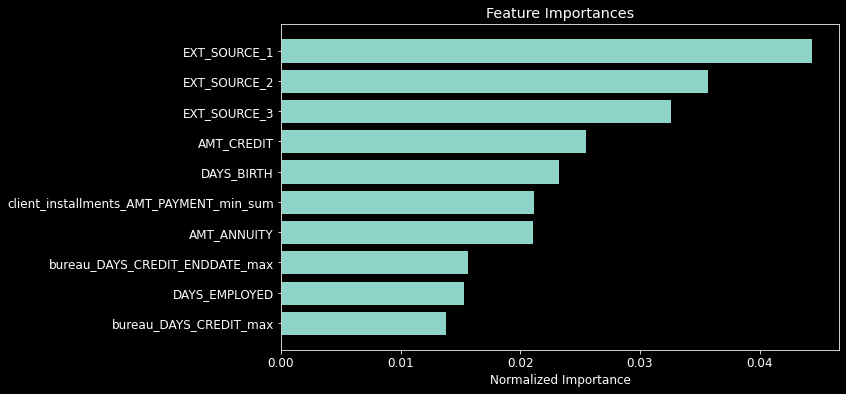

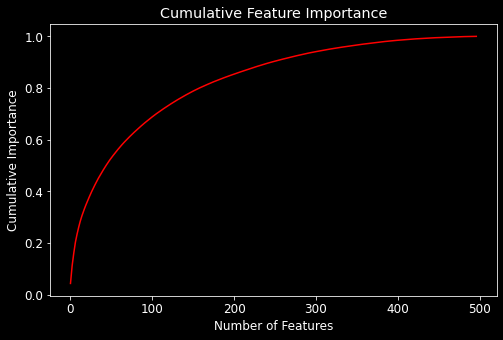

317 features required for 0.95 of cumulative importance.


In [61]:
# plotting features importance
fi_sorted = plot_feature_importances(feature_importances, threshold=0.95, nb_feat=10)

In [62]:
fi_sorted.head(10)

,index,feature,importance,importance_normalized,cumulative_importance
0,17,EXT_SOURCE_1,133.2,0.044400,0.044400
1,18,EXT_SOURCE_2,107.0,0.035667,0.080067
2,19,EXT_SOURCE_3,97.8,0.032600,0.112667
3,2,AMT_CREDIT,76.4,0.025467,0.138133
4,5,DAYS_BIRTH,69.8,0.023267,0.161400
5,240,client_installments_AMT_PAYMENT_min_sum,63.4,0.021133,0.182533
6,3,AMT_ANNUITY,63.2,0.021067,0.203600
7,117,bureau_DAYS_CREDIT_ENDDATE_max,47.0,0.015667,0.219267
8,6,DAYS_EMPLOYED,45.8,0.015267,0.234533
9,108,bureau_DAYS_CREDIT_max,41.4,0.013800,0.248333


We can notice that among the 10 most important features 7 are from the initial application_train database.

### Reduction of the test database

At this stage we have a selection of features adapted to the LGBMClassifier model. For the final part of the project (i.e. the dynamic graphics application) we will need all the data available (including those of the test base). Therefore we alogn the two dataframes to keep the exact same features.

In [63]:
# Save the TARGET (will be lost in aligning process)
train_labels = train['TARGET']

In [64]:
# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (307511, 498)
test shape:  (48744, 498)


In [65]:
# Restore of the TARGET values
train['TARGET'] = train_labels

### Saving of the very final bases

We finally have two reduced bases with "only" 498 features (without the SK_ID_CURR and TARGET ones which are respectively an indentification code and the target of the incomming model). Compared to the more than 1900 features of the databases at the end of the aggregations, this is a great reduction (almost a factor of four).

In [83]:
train.to_csv('train_SmallGlobalBase.csv', index = False)
test.to_csv('test_SmallGlobalBase.csv', index = False)

End of the second notebook.  
The next one will be devoted to the optimization of the LGBMClassifier model by determining the optimal values of a selection of hyperparameters.